In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
"""     ====>     initial parameters     <====     """
'''QDS'''
n = 24   #number of QDs
R = 3   #radius of QD setup
diam = 50e-9    #diameter of QD (atm made up)
ts = 30e-9 #double quoted 15ns, time spent stopped between steps, time needed to discharge and charge quantum dot
'''Permanent Charges'''
p = 12   #number of permanent charges (PCs)
Rp = 2   #radius of rotating disc
r = 1    #length of the cog shaft
thc = 30e-9   #approximate thickeness of inner disc
ro = 3e3 #kg/m^3, desity of inner disc material (approxmiate)
vol = 1   #applied voltage to capacitors in inner disck ("permanent charges"/charged segments)
cd = 0.394    #capacitance density in F/m^2 of inner segment capacitors
'''Other constants'''
eps = 8.854e-12 #currently set to epsilon 0
k = 1/(4*math.pi*eps)
e = 1.60217662e-19
r0 = R - Rp   #distance between roatating disc and centre of QD setup above
nu = 0.0000000000000001    #viscosity

In [3]:
def intertia( ro, thc, Rp):
    """Calculates inertia of inner rotating disk"""
    I = 0.5 * ro * math.pi * thc * ( Rp ** 4 )
    return I

In [4]:
def permanent_charge_magnitude( Rp, p , cd, vol):
    """Calculates magnitude of total charge stored in inner segment"""
    segment_area = (3*math.pi*(Rp**2))/(4*p) #see notebook for deriviation
    capacitance = cd * segment_area #capacitance of one segment
    stored_charge = capacitance * vol #stored charge in one segment
    return stored_charge

In [5]:
def permanent_charges( Rp, p , cd, vol):
    PCs = {}
    for i in range(p):
        theta = (2*math.pi/p)*i
        xp = Rp*math.cos(theta)
        yp = Rp*math.sin(theta)
        if i%2 == 0:
            p_ch = permanent_charge_magnitude( Rp, p , cd, vol)
        else:
            p_ch = -permanent_charge_magnitude( Rp, p , cd, vol)
        PCs.update({i:[xp,yp,theta, p_ch]})
    return PCs

In [6]:
def quantum_dots( n, e):
    QDs = {}
    for i in range(n):
        fi = (2*math.pi/n)*i
        x = R*math.cos(fi)
        y = R*math.sin(fi)
        if i in range(1, 24, 4):
            q_ch = 2*e
        elif i in range(3,24,4):
            q_ch = -2*e
        else:
            q_ch = 0
        QDs.update({i:[x,y,fi,q_ch]})
    return QDs

In [7]:
def tangential_component(n, e, R, r0, gamma):
    F_c = 0; #To work out force in polar I need to know distance from the PC to each QD
    F_t = 0
    QDs = quantum_dots(n,e)
    for i in range(n):
        Q = QDs[i]
        ri = math.sqrt(2*R*(R-r0)*(1-math.cos(QDs[i][2]-gamma))+r0**2)
        F_c += k*PCs[0][3]*Q[3]/(ri**2)
        d = 2*R*math.sin((QDs[i][2]-gamma)/2)
        alpha = math.acos(((r0**2)+(ri**2)-(d**2))/(2*r0*ri))
        if i > n/2:
            alpha = -alpha
        F_t += F_c*math.sin(alpha)
    return F_t

In [8]:
def torque (F_t, Rp, p):
    torque = F_t * Rp * p
    return torque

In [9]:
def time_step(I, torque, angle_increment):
    return math.sqrt((2*angle_increment*I)/torque)

In [10]:
def angular_velocity(angle_increment, tau):
    return angle_increment/tau

In [11]:
def viscous_force(ang_v, nu, r):
    return ang_v*nu/r

In [12]:
def charging_energy():
    C_dot = 2*math.pi*eps*diam
    E_c = (4*(e**2))/(2*C_dot)
    return E_c

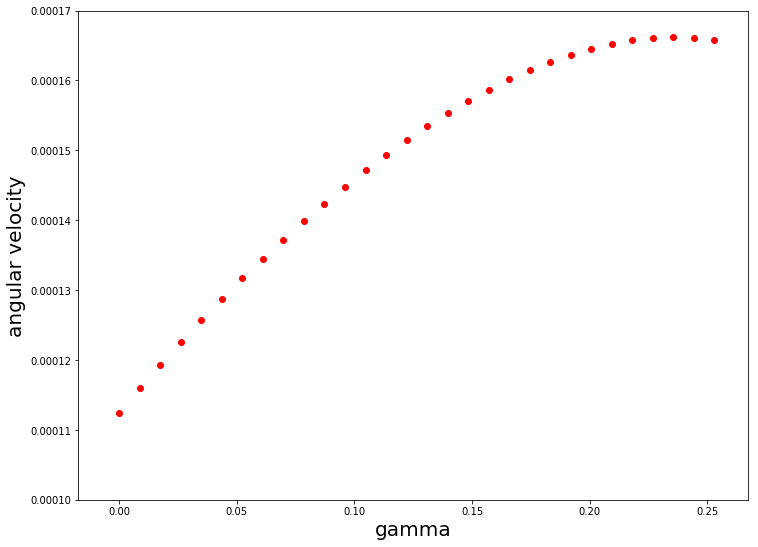

In [13]:
ang_v = []
deg15 = math.pi*15/180
PCs = permanent_charges( Rp, p , cd, vol)

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111)
plt.ylim(0.0001, 0.00017)
plt.xlabel('gamma', fontsize = '20')
plt.ylabel('angular velocity', fontsize = '20')

v_a = 0
for gamma in np.arange(0, deg15 , deg15/30):
    F_n = viscous_force(v_a, nu, r)
    F_t = tangential_component(n, e, R, r0, gamma)
    #print F_t - F_n
    tau = time_step(intertia( ro, thc, Rp), torque (F_t-F_n, Rp, p), deg15/30)
    v_a = angular_velocity(deg15/30, tau)
    ax.scatter(gamma, v_a, color = 'r')
    ang_v.append(v_a)
#print ang_v
plt.show()